In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import time
import random
import torch.nn.functional as loss_function
from helper.load import LoadDatasets
import helper.model as models

# SETTINGS

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device run on', 'cuda' if torch.cuda.is_available() else 'cpu')

SEED_CODE = 1380
LEARNING_RATE = 0.0002
NUM_EPOCHS = 5
BATCH_SIZE = 128

IMAGE_HW, IMAGE_CHANNELS = 64, 3


def set_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seeds(SEED_CODE)

Device run on cuda


# Dataset

Image Size: torch.Size([128, 3, 64, 64])


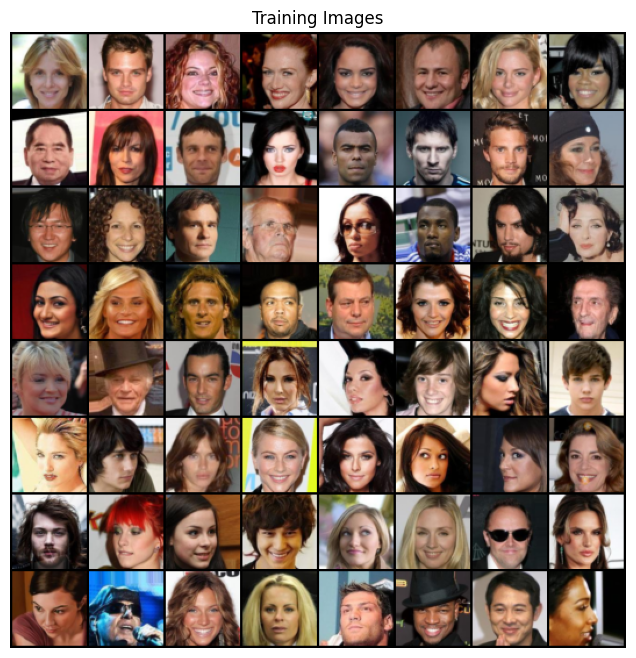

In [3]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HW, IMAGE_HW]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_dataset = LoadDatasets(root=os.getcwd()+'/data/celeba/img_align_celeba', transform=custom_transforms)

train_loader = torch.utils.data.DataLoader(dataset=image_dataset,
                                           batch_size=BATCH_SIZE, num_workers=0, shuffle=True)


for images in train_loader:
    print('Image Size:', images.size())
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64], normalize=True), (1, 2, 0)))
    break

In [4]:
model = models.DCGAN_With_Sigmoid_ReLU()
model.to(DEVICE)

DCGAN_With_Sigmoid_ReLU(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [5]:
optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=LEARNING_RATE)


def train(num_epochs, model, train_loader, print_step=100, save_model=None):

    result = {'train_generator_loss_per_batch': [],
              'train_discriminator_loss_per_batch': []}

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_id, features in enumerate(train_loader):

            batch_size = features.size(0)

            real_images = features.to(DEVICE)
            real_labels = torch.ones(
                batch_size, device=DEVICE) 

            noise = torch.randn(batch_size, 100, 1,
                                1, device=DEVICE)  
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(
                batch_size, device=DEVICE)  
            flipped_fake_labels = real_labels 

            # Train Discriminator

            optim_discr.zero_grad()
            # Loss on Real images
            discr_pred_real = model.discriminator_forward(
                real_images).view(-1) 
            real_loss = loss_function.binary_cross_entropy_with_logits(
                discr_pred_real, real_labels)


            # loss on fake images
            discr_pred_fake = model.discriminator_forward(
                fake_images.detach()).view(-1)
            fake_loss = loss_function.binary_cross_entropy_with_logits(
                discr_pred_fake, fake_labels)
         

            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optim_discr.step()

            # Train Generator
            optim_gen.zero_grad()

            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_function.binary_cross_entropy_with_logits(
                discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optim_gen.step()

            result['train_generator_loss_per_batch'].append(
                gener_loss.item())
            result['train_discriminator_loss_per_batch'].append(
                discr_loss.item())

            if not batch_id % print_step:
                print('Epoch: %d/%d | Batch %d/%d | Gen/Dis Loss: %f/%f'
                      % (epoch+1, num_epochs, batch_id,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return result


result = train(num_epochs=NUM_EPOCHS, model=model,
                 train_loader=train_loader,
                 save_model='Model.pt')


Epoch: 1/5 | Batch 0/1583 | Gen/Dis Loss: 4.305223/0.734214
Epoch: 1/5 | Batch 100/1583 | Gen/Dis Loss: 8.160238/0.000633
Epoch: 1/5 | Batch 200/1583 | Gen/Dis Loss: 9.121805/0.000131
Epoch: 1/5 | Batch 300/1583 | Gen/Dis Loss: 9.638161/0.000069
Epoch: 1/5 | Batch 400/1583 | Gen/Dis Loss: 10.221760/0.000036
Epoch: 1/5 | Batch 500/1583 | Gen/Dis Loss: 10.652174/0.000016
Epoch: 1/5 | Batch 600/1583 | Gen/Dis Loss: 10.879150/0.000016
Epoch: 1/5 | Batch 700/1583 | Gen/Dis Loss: 11.311086/0.000010
Epoch: 1/5 | Batch 800/1583 | Gen/Dis Loss: 11.560133/0.000009
Epoch: 1/5 | Batch 900/1583 | Gen/Dis Loss: 11.775789/0.000006
Epoch: 1/5 | Batch 1000/1583 | Gen/Dis Loss: 11.903797/0.000008
Epoch: 1/5 | Batch 1100/1583 | Gen/Dis Loss: 11.922781/0.000004
Epoch: 1/5 | Batch 1200/1583 | Gen/Dis Loss: 11.991470/0.000004
Epoch: 1/5 | Batch 1300/1583 | Gen/Dis Loss: 12.252956/0.000004
Epoch: 1/5 | Batch 1400/1583 | Gen/Dis Loss: 12.599564/0.000003
Epoch: 1/5 | Batch 1500/1583 | Gen/Dis Loss: 12.710067/0

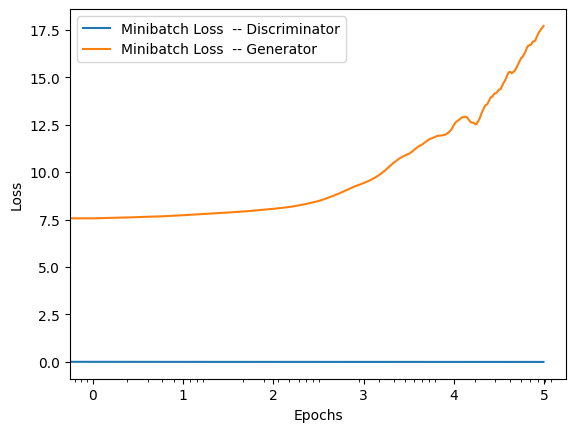

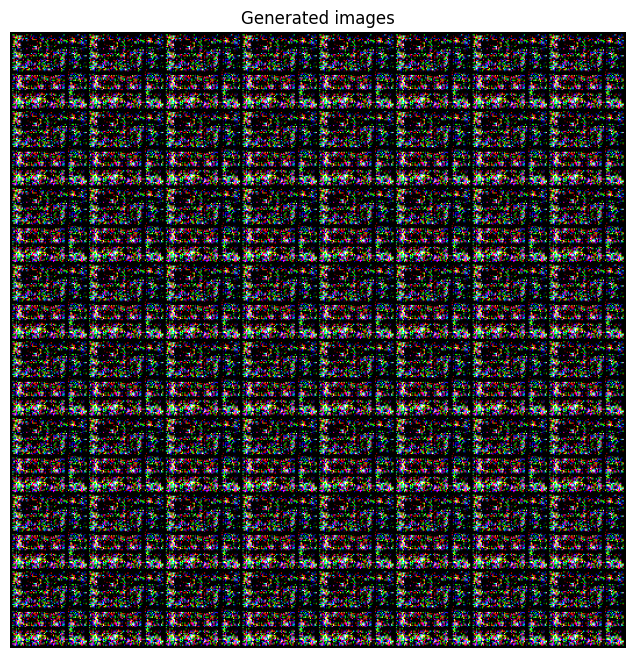

In [6]:
##########################
# VISUALIZATION
##########################

def plot_training_losses(losses_list, num_epochs, averaging_iterations=100, custom_labels_list=None):
    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(losses_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    for i, loss_tensor in enumerate(losses_list):
        smoothed_loss = moving_average(loss_tensor, averaging_iterations)
        plt.plot(smoothed_loss, label=f'Minibatch Loss {custom_labels_list[i]}')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.xscale('log')
    plt.xticks(np.logspace(0, np.log10(len(loss_tensor)), num_epochs+1, base=10), range(num_epochs+1))
    plt.xlabel('Epochs')
    plt.show()

def moving_average(arr, window):
    return np.convolve(arr, np.ones(window)/window, mode='valid')



plot_training_losses(
    losses_list=(result['train_discriminator_loss_per_batch'],
                 result['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

noise = torch.randn(64, 100, 1, 1, device=DEVICE)
fake_images = model.generator_forward(noise).detach().cpu()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    fake_images, normalize=True), (1, 2, 0)))
plt.show()